<a href="https://colab.research.google.com/github/kwanhong66/KaggleShoveling/blob/master/Air_Pollution_in_Seoul_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset with Kaggle API

In [0]:
!pip3 install -q kaggle

In [2]:
!wget 'https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json'

--2020-06-11 05:24:59--  https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      63  --.-KB/s    in 0s      

2020-06-11 05:24:59 (3.19 MB/s) - ‘kaggle.json’ saved [63/63]



In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download bappekim/air-pollution-in-seoul

 46% 9.00M/19.7M [00:00<00:00, 47.0MB/s]
100% 19.7M/19.7M [00:00<00:00, 78.2MB/s]


In [0]:
!mkdir input

In [7]:
!unzip '*.zip' -d ./input/

Archive:  air-pollution-in-seoul.zip
  inflating: ./input/AirPollutionSeoul/Measurement_summary.csv  
  inflating: ./input/AirPollutionSeoul/Original Data/Measurement_info.csv  
  inflating: ./input/AirPollutionSeoul/Original Data/Measurement_item_info.csv  
  inflating: ./input/AirPollutionSeoul/Original Data/Measurement_station_info.csv  


## Notes

These codes are originated from below kernels:

* https://www.kaggle.com/ramontanoeiro/seoul-air-pollution
* https://www.kaggle.com/seriousran/eda-ing
* https://www.kaggle.com/bappekim/visualizing-the-location-of-station-using-folium

Based on these, original code will be added more and more.

## Preparing data

### Import packages

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load data

We can see the explanation of dataset in data description section.

In [0]:
df_summary = pd.read_csv('./input/AirPollutionSeoul/Measurement_summary.csv')  # A condensed dataset based on the below three data.
df_info = pd.read_csv('./input/AirPollutionSeoul/Original Data/Measurement_info.csv')  # Air pollution measurement information
df_item = pd.read_csv('./input/AirPollutionSeoul/Original Data/Measurement_item_info.csv')  #  Information on air pollution measurement items
df_station = pd.read_csv('./input/AirPollutionSeoul/Original Data/Measurement_station_info.csv')  # Information on air pollution instrument stations

In [10]:
df_summary.head()

Measurement date  Station code  ...  PM10  PM2.5
0  2017-01-01 00:00           101  ...  73.0   57.0
1  2017-01-01 01:00           101  ...  71.0   59.0
2  2017-01-01 02:00           101  ...  70.0   59.0
3  2017-01-01 03:00           101  ...  70.0   58.0
4  2017-01-01 04:00           101  ...  69.0   61.0

[5 rows x 11 columns]

## Exploring data

### Inspecting columns

This data was measured every hour between 2017 and 2019 thus `Measurement date` column has `date` + `time` data.

It has to be splitted into date and time into separate columns to see daily data visualization.

In [11]:
date_time = df_summary['Measurement date'].str.split(' ', n=1, expand=True)
date_time.head()

0      1
0  2017-01-01  00:00
1  2017-01-01  01:00
2  2017-01-01  02:00
3  2017-01-01  03:00
4  2017-01-01  04:00

In [12]:
df_summary['date'] = date_time[0]
df_summary['time'] = date_time[1]
df_summary = df_summary.drop(['Measurement date'], axis=1)
df_summary.head()

Station code  ...   time
0           101  ...  00:00
1           101  ...  01:00
2           101  ...  02:00
3           101  ...  03:00
4           101  ...  04:00

[5 rows x 12 columns]

The dataset is from 25 districts in Seoul.

As we saw above, `Station code`, `Address`, `Latitude` and `Longitude` columns explain for locations. We can check all of these columns have distinct 25 values.

In [13]:
# print(df_summary['Station code'].unique())
print("`Station code` column has {} distinct values".format(df_summary['Station code'].nunique()))

# print(df_summary['Address'].unique())
print("`Address` column has {} distinct values".format(df_summary['Address'].nunique()))

# print(df_summary['Latitude'].unique())
print("`Latitude` column has {} distinct values".format(df_summary['Latitude'].nunique()))

# print(df_summary['Longitude'].unique())
print("`Longitude` column has {} distinct values".format(df_summary['Longitude'].nunique()))

`Station code` column has 25 distinct values
`Address` column has 25 distinct values
`Latitude` column has 25 distinct values
`Longitude` column has 25 distinct values


### Measurement variables validation check

In [14]:
df_summary.describe()

Station code       Latitude  ...           PM10          PM2.5
count  647511.000000  647511.000000  ...  647511.000000  647511.000000
mean      113.000221      37.553484  ...      43.708051      25.411995
std         7.211315       0.053273  ...      71.137342      43.924595
min       101.000000      37.452357  ...      -1.000000      -1.000000
25%       107.000000      37.517528  ...      22.000000      11.000000
50%       113.000000      37.544962  ...      35.000000      19.000000
75%       119.000000      37.584848  ...      53.000000      31.000000
max       125.000000      37.658774  ...    3586.000000    6256.000000

[8 rows x 9 columns]

We can see that there are some -1 values on thes pollutant columns, which should not be possible. This might be wrong reading fo the instrument used to measure pollutants. Or -1 value could means NA value.

We will search and drop them.

In [15]:
print('We have {} negative values for SO2'.format(df_summary['SO2'].loc[df_summary['SO2'] < 0].count()))
print('We have {} negative values for NO2'.format(df_summary['NO2'].loc[df_summary['NO2'] < 0].count()))
print('We have {} negative values for O3'.format(df_summary['O3'].loc[df_summary['O3'] < 0].count()))
print('We have {} negative values for CO'.format(df_summary['CO'].loc[df_summary['CO'] < 0].count()))
print('We have {} negative values for PM10'.format(df_summary['PM10'].loc[df_summary['PM10'] < 0].count()))
print('We have {} negative values for PM2.5'.format(df_summary['PM2.5'].loc[df_summary['PM2.5'] < 0].count()))

We have 3976 negative values for SO2
We have 3834 negative values for NO2
We have 4059 negative values for O3
We have 4036 negative values for CO
We have 3962 negative values for PM10
We have 3973 negative values for PM2.5


In [0]:
import plotly
import plotly.graph_objs as go
import plotly.offline as py
import plotly.io as pio
pio.renderers.default = 'colab'
# plotly.offline.init_notebook_mode(connected=True)

In [17]:
# 
to_drop = df_summary.loc[(df_summary['SO2']<0) | (df_summary['NO2']<0) | (df_summary['CO']<0) | (df_summary['O3']<0)]
print("Total number of to_drop records is {}".format(to_drop.shape[0]))
to_drop.head()

Total number of to_drop records is 4529


Station code  ...   time
854           101  ...  14:00
855           101  ...  15:00
856           101  ...  16:00
857           101  ...  17:00
858           101  ...  18:00

[5 rows x 12 columns]

We could suspect that something was wrong at the same day thus measurement had worng value.

In [0]:
# drop records which contains columns having negative value
df_summary.drop(to_drop.index, axis=0, inplace=True)

In [19]:
# Gas pollutants
# Sampling a single station data
sample_101 = df_summary.loc[df_summary['Station code'] == 101]
data = [go.Scatter(x=sample_101['date'],
                   y=sample_101['SO2']),
        go.Scatter(x=sample_101['date'],
                   y=sample_101['NO2']),
        go.Scatter(x=sample_101['date'],
                   y=sample_101['O3']),
        go.Scatter(x=sample_101['date'],
                   y=sample_101['CO'])]

layout = go.Layout(title='Gases Levels after dropping negative value (Sample - Station code: 101)',
                   yaxis={'title': 'Level (ppm)'},
                   xaxis={'title': 'Date'})                   

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

In [20]:
# check negative value drop result
gas_pollutants = df_summary[['SO2', 'NO2', 'O3', 'CO']]
gas_pollutants.apply(lambda x: x < 0).sum().sum()

0

In [21]:
# PM pollutatns
data = [go.Scatter(x=sample_101['date'],
                   y=sample_101['PM2.5']),
        go.Scatter(x=sample_101['date'],
                   y=sample_101['PM10'])]

layout = go.Layout(title='PM level (Sample - Station code: 101)',
                   yaxis={'title': 'Level (ppm)'},
                   xaxis={'title': 'Date'})                   

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

In [22]:
to_drop_PM = df_summary.loc[(df_summary['PM2.5']<0) | (df_summary['PM10']<0) | 
                            (df_summary['PM2.5']==0) | (df_summary['PM10']==0)]
to_drop_PM.head()

Station code  ...   time
2247           101  ...  15:00
3255           101  ...  15:00
3467           101  ...  11:00
3953           101  ...  17:00
4142           101  ...  14:00

[5 rows x 12 columns]

In [0]:
df_summary.drop(to_drop_PM.index, axis=0, inplace=True)

In [24]:
# check negative and zero value drop result
pm_pollutants = df_summary[['PM2.5', 'PM10']]
pm_pollutants.apply(lambda x: x <= 0).sum().sum()

0

### Plotting total data daily basis

In [25]:
df_seoul_daily = df_summary.groupby(['date'], as_index=False).agg({
    'SO2': 'mean', 'NO2': 'mean', 'O3': 'mean', 'CO': 'mean', 'PM10': 'mean', 'PM2.5': 'mean',
})
df_seoul_daily.head()

date       SO2       NO2        O3        CO        PM10      PM2.5
0  2017-01-01  0.005302  0.046509  0.004152  0.985142   77.332220  56.869783
1  2017-01-02  0.005970  0.039572  0.016533  0.891568  110.532884  78.762226
2  2017-01-03  0.005641  0.042332  0.013264  0.769865   79.188552  51.959596
3  2017-01-04  0.005817  0.050734  0.008628  0.884590   55.244556  34.708543
4  2017-01-05  0.004798  0.035620  0.011401  0.659532   36.362876  22.244147

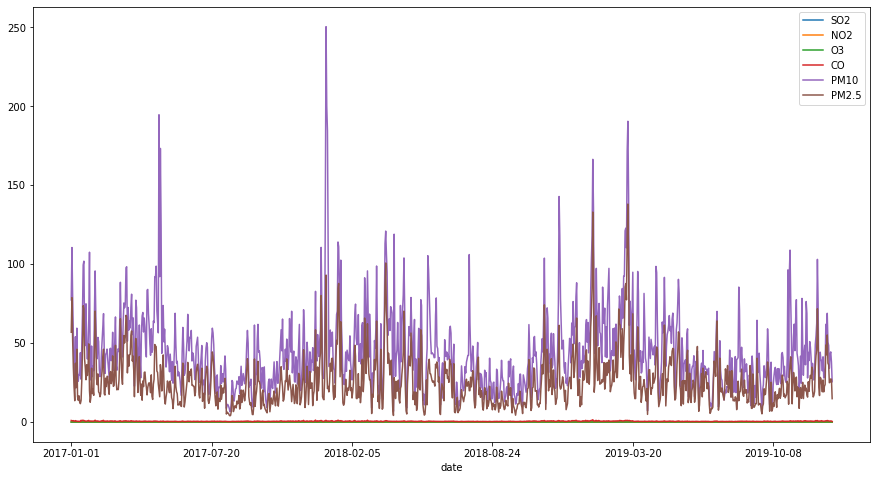

In [26]:
df_seoul_daily.plot(x='date', figsize=(15,8))

Daily mean value of all six pollutants are plotted in a single diagram.

As we can saw in `df_seoul_daily.head()`, scales of each pollutants are varying thus we could not see any other daily mean values other than `PM10` and `PM2.5`, which have large scales.

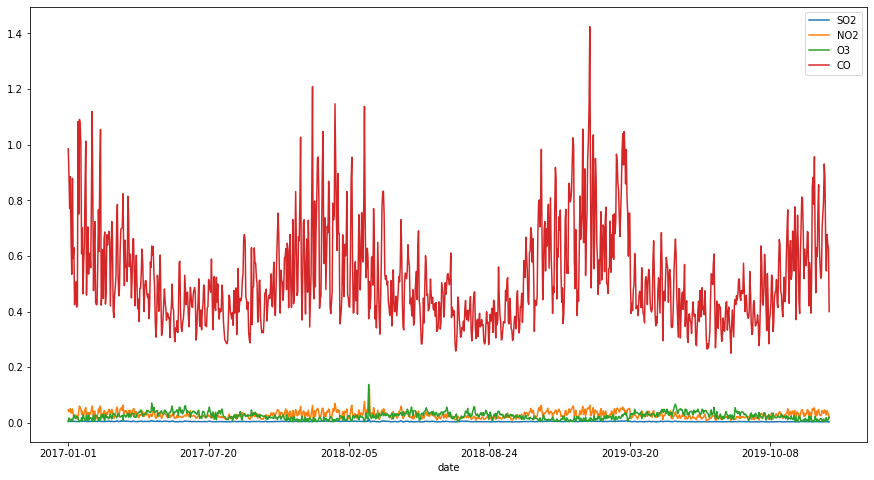

In [27]:
df_seoul_daily[['date', 'SO2', 'NO2', 'O3', 'CO']].plot(x='date', figsize=(15,8))

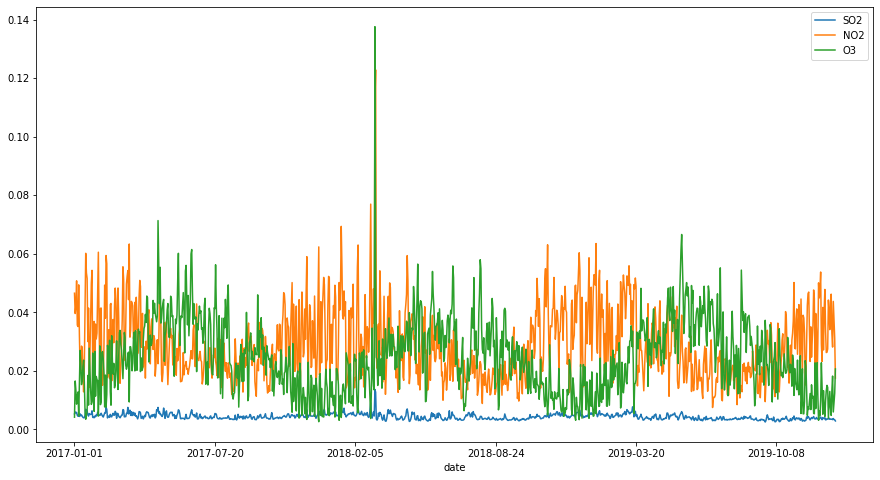

In [106]:
df_seoul_daily[['date', 'SO2', 'NO2', 'O3']].plot(x='date', figsize=(15,8))

### Correlations between pollutant variables

**NOTES for novice like me**

We want see how pollutant variavles are related each other(correlation analysis). But pollutant variables have different scales. It might be worry for standardization if we don't know what Pearson correlation coefficient means and is for.

**ρxy​=​Cov(x,y)​ / (σx​σy)** (Pearson correlation coefficient)

Correlation is normalized by standard deviation. Therefore, no need to normalize them.
By definition the correlation coefficient is independent of change of origin and scale. As such standardization will not alter the value of correlation.

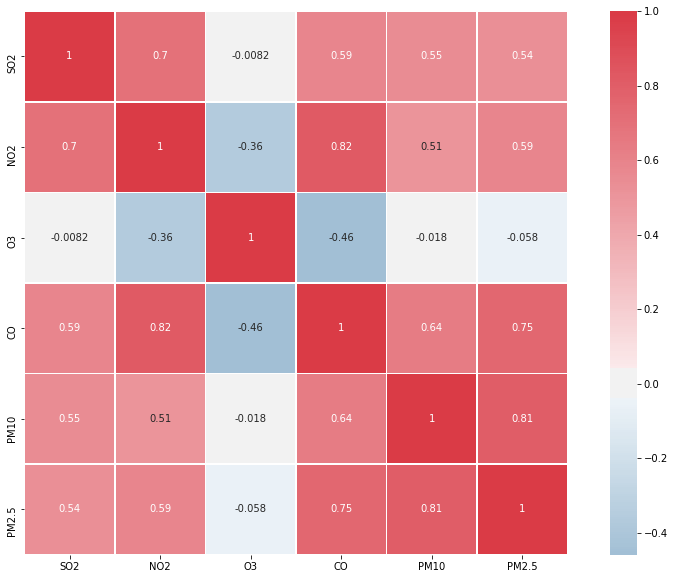

In [28]:
pollutant_corr = df_seoul_daily.corr()  # Pearson correlation
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(pollutant_corr, cmap=cmap, annot=True, vmax=1, center=0,
            square=True, linewidth=.5)

There are highly related variables as follows:

* `SO2` and `NO2` (0.86)
* `SO2` and `O3` (0.84)
* `PM2.5` and `CO` (0.75)
* `PM2.5` and `PM10` (0.81)

### PM10 data (Particle Matter 10)

South Korea **PM10** enviornmental standards (daily mean)

* Good 0~30
* Not Bad ~80
* Bad ~150
* Very Bad 151~

In [48]:
df_item.head()

Item code Item name  ... Bad(Yellow)  Very bad(Red)
0          1       SO2  ...        0.15            1.0
1          3       NO2  ...        0.20            2.0
2          5        CO  ...       15.00           50.0
3          6        O3  ...        0.15            0.5
4          8      PM10  ...      150.00          600.0

[5 rows x 7 columns]

In [29]:
df_seoul_daily.loc[df_seoul_daily['PM10'] <= 30, 'PM10_class'] = 0
df_seoul_daily.loc[(df_seoul_daily['PM10'] > 30) & (df_seoul_daily['PM10'] <= 80), 'PM10_class'] = 1
df_seoul_daily.loc[(df_seoul_daily['PM10'] > 80) & (df_seoul_daily['PM10'] <= 150), 'PM10_class'] = 2
df_seoul_daily.loc[(df_seoul_daily['PM10'] > 151), 'PM10_class'] = 3
df_seoul_daily['PM10_class'] = df_seoul_daily['PM10_class'].astype(int)
df_seoul_daily.head()

date       SO2       NO2  ...        PM10      PM2.5  PM10_class
0  2017-01-01  0.005302  0.046509  ...   77.332220  56.869783           1
1  2017-01-02  0.005970  0.039572  ...  110.532884  78.762226           2
2  2017-01-03  0.005641  0.042332  ...   79.188552  51.959596           1
3  2017-01-04  0.005817  0.050734  ...   55.244556  34.708543           1
4  2017-01-05  0.004798  0.035620  ...   36.362876  22.244147           1

[5 rows x 8 columns]

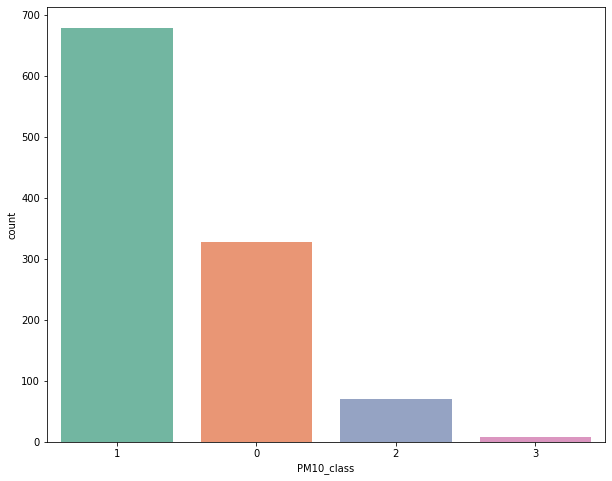

In [30]:
plt.figure(figsize=(10, 8))
sns.countplot(data=df_seoul_daily, x='PM10_class', order=df_seoul_daily['PM10_class'].value_counts().index,
              palette='Set2')

In [35]:
data = [go.Scatter(x=sample_101['date'],
                   y=sample_101['PM10'])]

layout = go.Layout(title='PM10 Levels (Sample - Station code: 101)',
                   xaxis={'title': 'Date'},
                   yaxis={'title': 'Level (ppm)'})

fig = go.Figure(data=data, layout=layout)

# `Good` horizontal line
fig.add_shape(
    type='line',
    x0='2017-01-01',
    y0=30,
    x1='2019-12-31',
    y1=30,
    line=dict(
        color='Green',
        width=5,
        dash='dashdot'
    )
)

# `Not Bad` horizontal line
fig.add_shape(
    type='line',
    x0='2017-01-01',
    y0=80,
    x1='2019-12-31',
    y1=80,
    line=dict(
        color='Yellow',
        width=5,
        dash='dashdot'
    )
)

py.iplot(fig)

### Location based exploration

TOP 5 average PM value

In [96]:
pm10_top5 = df_summary.groupby(by='Station code').agg({'PM10': 'mean'}).sort_values(by='PM10', ascending=False).head(5).reset_index()
pm10_top5_st_codes = pm10_top5['Station code'].tolist()
print('PM Top 5 station codes: {}'.format(pm10_top5_st_codes))
pm10_top5_district = df_station.set_index('Station code').loc[pm10_top5_st_codes].reset_index()['Station name(district)']
pm10_top5.insert(loc=1, column='Station name(district)', value=pm10_top5_district)
pm10_top5

PM Top 5 station codes: [116, 122, 117, 119, 107]


Station code Station name(district)       PM10
0           116             Gangseo-gu  55.666864
1           122              Seocho-gu  54.354234
2           117                Guro-gu  51.938636
3           119        Yeongdeungpo-gu  50.645773
4           107           Seongdong-gu  49.992369

From 2017 to 2019, Top 5 districts for average PM10 are `Ganseo-gu`, `Seocho-gu`, `Guro-gu`, `Yeongdeungpo-gu` and `Seongdong-gu`.

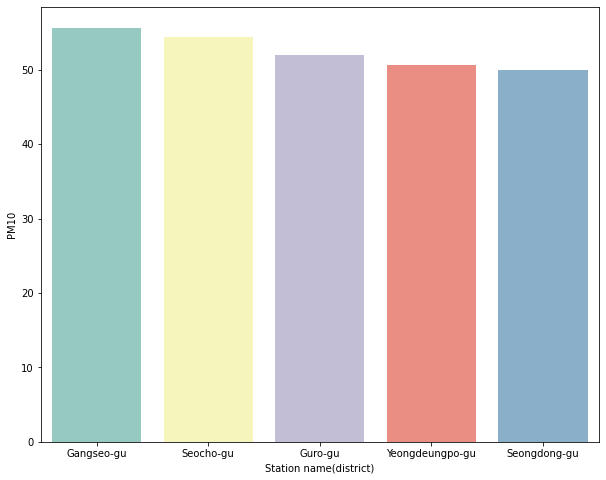

In [105]:
plt.figure(figsize=(10, 8))
sns.barplot(data=pm10_top5, x='Station name(district)', y='PM10', palette='Set3')

## Visualizing the location of station using polium

In [0]:
import requests
import folium
import json
import random

In [44]:
df_station.head()

Station code Station name(district)  ...   Latitude   Longitude
0           101              Jongno-gu  ...  37.572016  127.005008
1           102                Jung-gu  ...  37.564263  126.974676
2           103             Yongsan-gu  ...  37.540033  127.004850
3           104           Eunpyeong-gu  ...  37.609823  126.934848
4           105           Seodaemun-gu  ...  37.593742  126.949679

[5 rows x 5 columns]

In [46]:
center = [37.541, 126.986] # center of Seoul
m = folium.Map(location=center, zoom_start=11) # set map

# seoul district geo json
# https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo.json

seoul_geo_url = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo.json'
resp = requests.get(seoul_geo_url)
seoul_geo = json.loads(resp.text)

# Add GeoJson to map
# GeoJson: info for representing polygon(district, borderline)
folium.GeoJson(
    seoul_geo,
    name='seoul_municipalities',
).add_to(m)

# Add marker


for i in df_station.index[:]:
  marker_popup_str = 'Station Name: ' + str(df_station.loc[i, 'Station name(district)'])
  folium.Marker(df_station.loc[i, ['Latitude', 'Longitude']],
                popup=marker_popup_str,
                icon=folium.Icon(color='black')).add_to(m)

m                

In [47]:
df_item.head()

Item code Item name  ... Bad(Yellow)  Very bad(Red)
0          1       SO2  ...        0.15            1.0
1          3       NO2  ...        0.20            2.0
2          5        CO  ...       15.00           50.0
3          6        O3  ...        0.15            0.5
4          8      PM10  ...      150.00          600.0

[5 rows x 7 columns]

In [0]:
def get_criteria(df_item, poll_item):
  critera = df_item[df_item['Item name'] == poll_item].iloc[0, 3:]
  return critera

def seoul_pollutant_map(df_day, df_item, poll_item):
  """ Visualize pollutant item status of each district by color marker """

  criteria = get_criteria(df_item, poll_item)

  df_day_c = df_day.copy()

  # set color of marker
  df_day_c['color'] = ''
  df_day_c.loc[df_day_c[poll_item] <= criteria[3], 'color'] = 'red'
  df_day_c.loc[df_day_c[poll_item] <= criteria[2], 'color'] = 'orange' # yellow
  df_day_c.loc[df_day_c[poll_item] <= criteria[1], 'color'] = 'green'
  df_day_c.loc[df_day_c[poll_item] <= criteria[0], 'color'] = 'blue'

  center = [37.541, 126.986] # center of Seoul
  m = folium.Map(location=center, zoom_start=11) # set map
  
  seoul_geo_url = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo.json'
  resp = requests.get(seoul_geo_url)
  seoul_geo = json.loads(resp.text)

  # Add GeoJson to map
  folium.GeoJson(
      seoul_geo,
      name='seoul_municipalities',
  ).add_to(m)

  for i in df_day_c.index:
    marker_popup_str = 'Station : ' + str(df_day_c.loc[i, 'Station code']) + ':' + str(df_day_c.loc[i, poll_item])
    folium.Marker(df_day_c.loc[i, ['Latitude', 'Longitude']],
                  popup=marker_popup_str,
                  icon=folium.Icon(color=df_day_c.loc[i, 'color'])).add_to(m)

  return m

In [69]:
random.seed(0)
ind = random.randint(1, len(df_summary))

day = df_summary.loc[ind, 'date']
print(day)
df_day = df_summary[df_summary['date'] == day]
seoul_pollutant_map(df_day, df_item, 'PM10')

2018-10-07
